# Notebook #5: Modelos

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Librería para el acceso a variables y funciones
# -----------------------------------------------------------------------
import sys
sys.path.append("../../")
from src import soporte_predicciones as sp

In [3]:
df = pd.read_csv("../../datos/modelo2/csv_estandarizado.csv", index_col=0)

In [4]:
df.head()

,price,exterior,rooms,bathrooms,floor,hasLift,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,municipality,size_standard,distance_standard
0,750.0,1,1,1,3.0,1,0.0,0.0,0.0,1.0,0.0,0.0,705.633136,0.180254,-0.680228
1,750.0,1,2,1,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,735.546086,0.741674,0.018574
3,590.0,1,3,2,-3.0,0,0.0,0.0,0.0,1.0,0.0,0.0,641.457386,0.741674,3.122134
4,684.0,1,0,1,-3.0,-1,0.0,0.0,0.0,0.0,0.0,1.0,705.633136,-0.661876,-0.402564
5,600.0,1,2,1,3.0,0,0.0,0.0,0.0,1.0,0.0,0.0,646.457386,0.910100,1.623409


In [5]:
X = df.drop("price", axis = 1)
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Random Forest

In [6]:
params_rf = {
    'n_estimators': [40, 50, 60], # de árboles que queremos en nuestro bosque
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15, 20], # mínimo de datos que debe tener la madre
    'min_samples_leaf': [10, 15, 20], # mínimo de datos que debe tener el hijo
    'max_leaf_nodes': [70, 80, 100] # de nodos finales
}

In [31]:
modelo_final_rf, df_metricas_rf = sp.probar_modelo(X, y["price"].values, X_test, y_test, params_rf, RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 20, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.531739,29.359364,1592.367356,39.904478
test,0.593631,29.363623,1543.755560,39.290655


In [32]:
with open('../../modelos/rf_regressor.pkl', 'wb') as f:
    pickle.dump(modelo_final_rf, f)

- La métrica del R2 nos indica cuán de bien explican nuestras variables predictoras a la variable respuesta. Idealmente está lo más cercano a 1 posible. En este caso, podemos ver que es bajo.
- Vemos además que, tenemos un overfitting pequeño, que podríamos mejorar disminuyendo la cantidad de variables predictoras. Para eso, analizaremos la importancia de cada una.

In [9]:
df_importancia_rf = pd.DataFrame(modelo_final_rf.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)
df_importancia_rf

,Importancia
municipality,0.667137
size_standard,0.168632
distance_standard,0.070654
floor,0.055998
rooms,0.023859
hasLift,0.008694
exterior,0.002659
propertyType_studio,0.001851
propertyType_flat,0.000513
bathrooms,0.000000


<Axes: xlabel='Importancia', ylabel='None'>

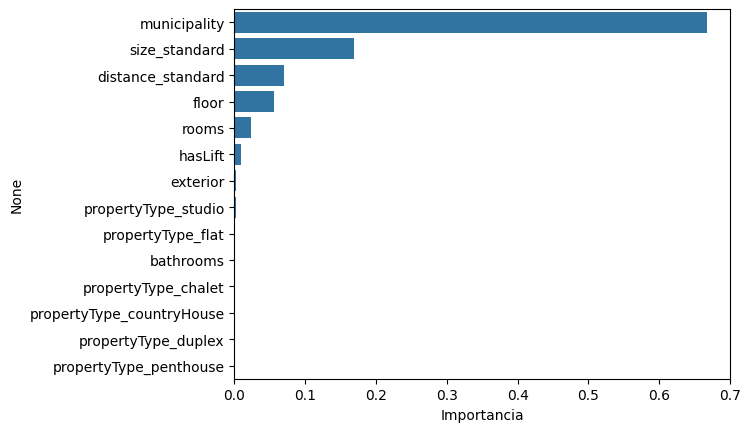

In [10]:
sns.barplot(x = "Importancia", y= df_importancia_rf.index, data = df_importancia_rf)

- Analizando la gráfica y el DF importancia, vemos que, hay muchas variables de las que podríamos prescindir, de cara a generar un modelo más preciso. Empezaremos por eliminar los propertyType, bathrooms y exterior.

In [14]:
df.columns

Index(['price', 'exterior', 'rooms', 'bathrooms', 'floor', 'hasLift',
       'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'municipality', 'size_standard',
       'distance_standard'],
      dtype='object')

In [16]:
X_train_reducida = X_train.drop(columns=['propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'bathrooms', 'exterior'])
X_test_reducida = X_test.drop(columns=['propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'bathrooms', 'exterior'])

In [18]:
params_rf_v2 = {
    'n_estimators': [50, 60, 70], # de árboles que queremos en nuestro bosque
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15, 20], # mínimo de datos que debe tener la madre
    'min_samples_leaf': [10, 15, 20], # mínimo de datos que debe tener el hijo
    'max_leaf_nodes': [80, 100, 120] # de nodos finales
}

In [ ]:
modelo_final_rf_v2, df_metricas_rf_v2 = sp.probar_modelo(X_train_reducida, y_train["price"].values, X_test_reducida, y_test, params_rf_v2, RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 15, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 60}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.475461,30.037896,1690.855897,41.120018
test,0.428542,35.090795,2170.911315,46.593039


- No vemos mejoras significativas, así que intentaremos eliminar las siguientes variables predictoras por importancia: hasLift y rooms.

In [28]:
X_train_reducida3 = X_train_reducida.drop(columns=["hasLift", "rooms"])
X_test_reducida3 = X_test_reducida.drop(columns=["hasLift", "rooms"])

In [29]:
params_rf_v3 = {
    'n_estimators': [50, 60, 70], # de árboles que queremos en nuestro bosque
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15, 20], # mínimo de datos que debe tener la madre
    'min_samples_leaf': [10, 15, 20], # mínimo de datos que debe tener el hijo
    'max_leaf_nodes': [80, 100, 120] # de nodos finales
}

In [30]:
modelo_final_rf_v3, df_metricas_rf_v3 = sp.probar_modelo(X_train_reducida3, y_train["price"].values, X_test_reducida3, y_test, params_rf_v3, RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 15, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 60}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.471844,30.234848,1702.514567,41.261539
test,0.413853,35.635644,2226.714315,47.188074


- Seguimos sin ver cambios significativos, esto implicaría que, eliminar variables no será suficiente para mejorar las métricas del modelo. Volveremos a la primera iteración (con todas las variables, y entrenaremos el modelo con el total de los datos.)

## Gradient Boosting

In [ ]:
params_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_leaf_nodes': [40]
}

In [ ]:
modelo_final_gb, df_metricas_gb = sp.probar_modelo(X_train, y_train["price"].values, X_test, y_test, params_gb, GradientBoostingRegressor())

Los mejores parámetros para el modelo con GradientBoostingRegressor() son:
    {'learning_rate': 0.01, 'max_depth': 5, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.569634,29.744091,1387.28720,37.246305
test,0.323401,38.121803,2570.33015,50.698424


- En este modelo, el overfitting es muy elevado, así que, no nos interesa seguir trabajando sobre él.